In [44]:
import ee
import ipyleaflet
import os
import requests
import shapely.geometry
import shapely.wkb
import json
ee.Initialize()

In [2]:
# utility funcs
def getTileLayerUrl(eeImage):
    map_id = ee.Image(eeImage).getMapId()
    tile_url_template = "https://earthengine.googleapis.com/map/{mapid}/{{z}}/{{x}}/{{y}}?token={token}"
    return tile_url_template.format(**map_id)

def TileLayer(eeImage):
    return ipyleaflet.TileLayer(url=getTileLayerUrl(eeImage))

def showLayer(eeImage):
    Map = ipyleaflet.Map(center=(48.2, 16.3), zoom=2, layout={'height':'200px'})
    Map.add_layer(TileLayer(eeImage))
    return Map

In [8]:
CARTO_URL = 'https://{}.carto.com/api/v2/sql'
CARTO_USER = 'wri-01'
CARTO_KEY = os.environ.get('CARTO_KEY')
def sendSql(sql, user=None, key=None):
    '''Send arbitrary sql and return response object or False'''
    user = user or CARTO_USER
    key = key or CARTO_KEY
    url = CARTO_URL.format(user)
    payload = {
        'api_key': key,
        'q': sql,
    }
    r = requests.post(url, json=payload)
    if (r.status_code >= 400):
        try:
            msg = r.json()['error'][0]
        except:
            r.raise_for_status()
        raise Exception(msg)
    return r.json()

In [3]:
img = ee.Image('users/benlaken/geodesriber-asset')
showLayer(img)

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [4]:
img.getInfo()

{'type': 'Image',
 'bands': [{'id': 'isMountain',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 255},
   'dimensions': [40076, 19363],
   'crs': 'EPSG:4326',
   'crs_transform': [0.008983152841195215,
    0.0,
    -180.00441663186973,
    0.0,
    -0.008983152841195215,
    86.80420590446937]},
  {'id': 'biome',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': -128,
    'max': 127},
   'dimensions': [40076, 19363],
   'crs': 'EPSG:4326',
   'crs_transform': [0.008983152841195215,
    0.0,
    -180.00441663186973,
    0.0,
    -0.008983152841195215,
    86.80420590446937]},
  {'id': 'ecoregion',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': -32768,
    'max': 32767},
   'dimensions': [40076, 19363],
   'crs': 'EPSG:4326',
   'crs_transform': [0.008983152841195215,
    0.0,
    -180.00441663186973,
    0.0,
    -0.008983152841195215,
    86.80420590446937]},
  {'id': 'koppen',
   'data_type': {'ty

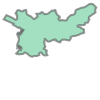

In [102]:
r = sendSql('select the_geom from gadm36_adm1 where cartodb_id = (random()*250)::integer')
geom = shapely.wkb.loads(r['rows'][0]['the_geom'], hex=True).simplify(.001)
region = ee.Geometry(shapely.geometry.mapping(geom))
geom

In [119]:
stats = img.reduceRegion(reducer=ee.Reducer.frequencyHistogram(),
                         geometry=region,
                         maxPixels=10000,
                         bestEffort=True
                         ).getInfo()
stats

{'biome': {'12': 1972.8470588235284},
 'ecoregion': {'794': 1283.3137254901956, '801': 689.533333333333},
 'intact2016': {'0': 1999.760784313724},
 'isMountain': {'0': 1506.2235294117631, '1': 493.53725490196047},
 'koppen': {'32': 22.19607843137255,
  '34': 1502.9921568627437,
  '35': 474.5725490196076}}

# Notes

For query
 - simplify query geometry if necessary
 - use bestEffort and maxPixels for on-the-fly resampling of raster

For constructing asset
 - cast to smaller memory size uint8 or uint16
 - resample to lower resolution if high res not necessary
 - project to equal-area if area matters